In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Understanding the Data

The full database consists of **lncRNA** (long non-enoding RNA) x **RBP** (RNA-Binding Protein) predicted binding interactions at each 101 nucleotide sequence along the lncRNAs resuling in an **36,000** dataframes of size **154** x **N<sub>i</sub>**, where **N<sub>i</sub>** represents the # of unique nucleotide segments in **lncRNA<sub>i</sub>** for **i = 1, ..., 36,000**.

Below is an example of the dataframe and and the predicted binding probabilites for **RBPs** (*AATF*, *ABCF1*, *AUH*, *BCCIP*,*BCLAF1*) along **lncRNA<sub>13</sub>** (*ENST00000366136.2*) with **N<sub>13</sub>** = 50.

,rna_index,dna_index,CSTF2T,DDX24,DDX42,DKC1
0,50,166081233,0.550342,0.121284,0.319533,0.307657
1,60,166081243,0.677120,0.150780,0.202503,0.491622
2,70,166082605,0.857351,0.275854,0.189750,0.902727
3,80,166082615,0.937038,0.446906,0.294754,0.933238
4,90,166082625,0.960428,0.561024,0.676668,0.977704


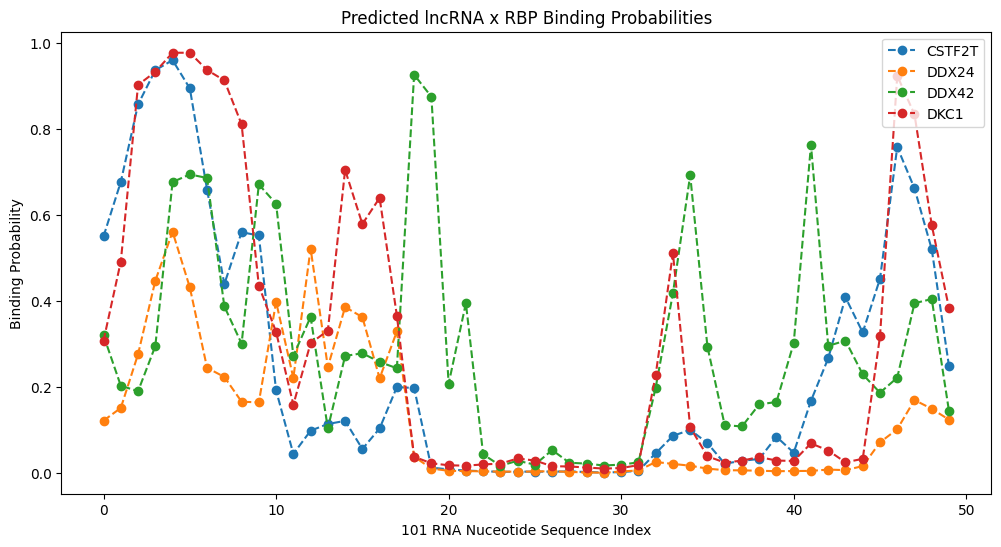

In [2]:
path = r"C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\lncRNA_x_RBP_Data\chr1\ENST00000366136.2_predictions.tsv"
df = pd.read_csv(path, sep='\t')
Index = 5
sample_proteins = df.columns[Index+2:Index+6]
display(df.loc[:, ['rna_index', 'dna_index'] + list(sample_proteins)].head())

plt.figure(figsize=(12, 6))
for rbp in sample_proteins:
    plt.plot(range(len(df)), df[rbp], marker='o', linestyle='--', label=rbp)
plt.title('Predicted lncRNA x RBP Binding Probabilities')
plt.xlabel('101 RNA Nuceotide Sequence Index')
plt.ylabel('Binding Probability')
plt.legend(loc='upper right')
plt.show()

This code creates a series of subplots to visualize the binding probabilities of RNA-binding proteins (RBPs) and their statistical properties within percentile bins. Each subplot shows the following:

1. **Binding Probabilities**: The binding probabilities of the RBP across the RNA sequence are plotted as a black dashed line with markers.
2. **Mean and Median Index Values**: The mean and median index values for each percentile bin are plotted as red scatter points.
3. **Error Bars**: Horizontal dashed lines represent the standard deviation around the mean index values.
4. **Bin Edges**: Horizontal dashed lines indicate the edges of the percentile bins.

The subplots provide a detailed view of the distribution and variability of binding probabilities for the first four RBPs in the dataset.

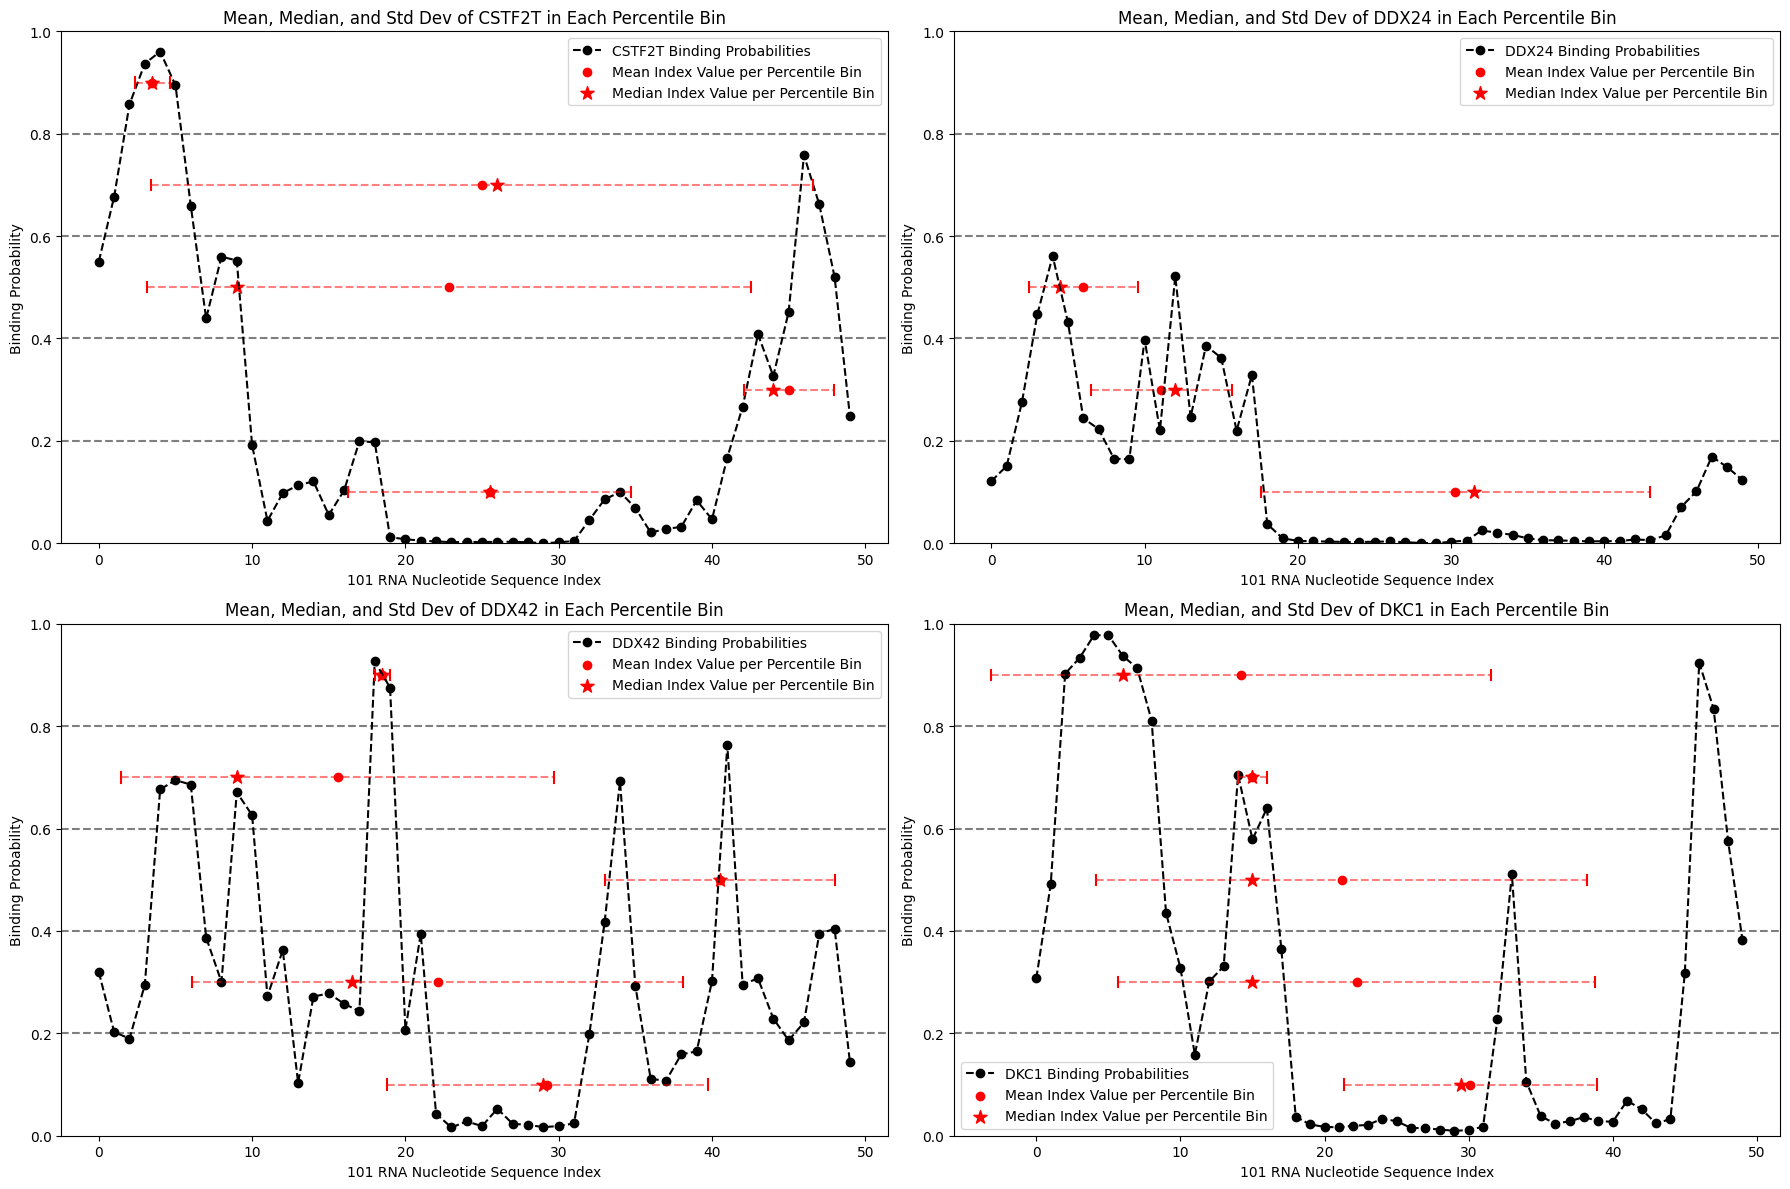

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, rbp in zip(axes.flatten(), sample_proteins):
    N = 5
    bps = df[rbp].values
    bins = np.linspace(0, 1, N + 1)
    bin_indices = np.digitize(bps, bins) - 1
    average_index_values = []
    variance_index_values = []
    median_index_values = []
    for i in range(N):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            average_index_values.append(indices_in_bin.mean())
            variance_index_values.append(indices_in_bin.var())
            median_index_values.append(np.median(indices_in_bin))
        else:
            average_index_values.append(np.nan)
            variance_index_values.append(np.nan)
            median_index_values.append(np.nan)
    y_coordinates = [(bins[i] + bins[i + 1]) / 2 for i in range(N)]
    ax.plot(range(len(df)), df[rbp], marker='o', linestyle='--', color='black', label=rbp + ' Binding Probabilities')
    ax.scatter(average_index_values, y_coordinates, color='red', label='Mean Index Value per Percentile Bin')
    ax.scatter(median_index_values, y_coordinates, color='red', marker='*', s=100, label='Median Index Value per Percentile Bin')
    for i in range(N):
        if not np.isnan(average_index_values[i]):
            lower_bound = average_index_values[i] - np.sqrt(variance_index_values[i])
            upper_bound = average_index_values[i] + np.sqrt(variance_index_values[i])
            ax.hlines(y_coordinates[i], lower_bound, upper_bound, colors='red', linestyles='dashed', alpha=0.5)
            ax.plot([lower_bound, lower_bound], [y_coordinates[i] - 0.01, y_coordinates[i] + 0.01], color='red')
            ax.plot([upper_bound, upper_bound], [y_coordinates[i] - 0.01, y_coordinates[i] + 0.01], color='red')
    for y in bins[1:-1]:
        ax.axhline(y, color='black', linestyle='--', alpha=0.5)
    ax.set_ylim(0, 1)
    ax.set_title(f'Mean, Median, and Std Dev of {rbp} in Each Percentile Bin')
    ax.set_xlabel('101 RNA Nucleotide Sequence Index')
    ax.set_ylabel('Binding Probability')
    ax.legend()
plt.tight_layout()
plt.show()

This code creates a series of subplots to visualize various statistical properties of RNA-binding proteins (RBPs) within percentile bins. Each subplot shows the following:

1. **Proportion of Binding Probabilities**: The proportion of binding probabilities in each percentile bin.
2. **Mean Index of Binding Probabilities**: The mean index values of binding probabilities in each percentile bin.
3. **Variance of Index of Binding Probabilities**: The variance of index values of binding probabilities in each percentile bin.
4. **Skewness of Index of Binding Probabilities**: The skewness of index values of binding probabilities in each percentile bin.

The subplots provide a detailed view of the distribution and variability of binding probabilities for the first four RBPs in the dataset.

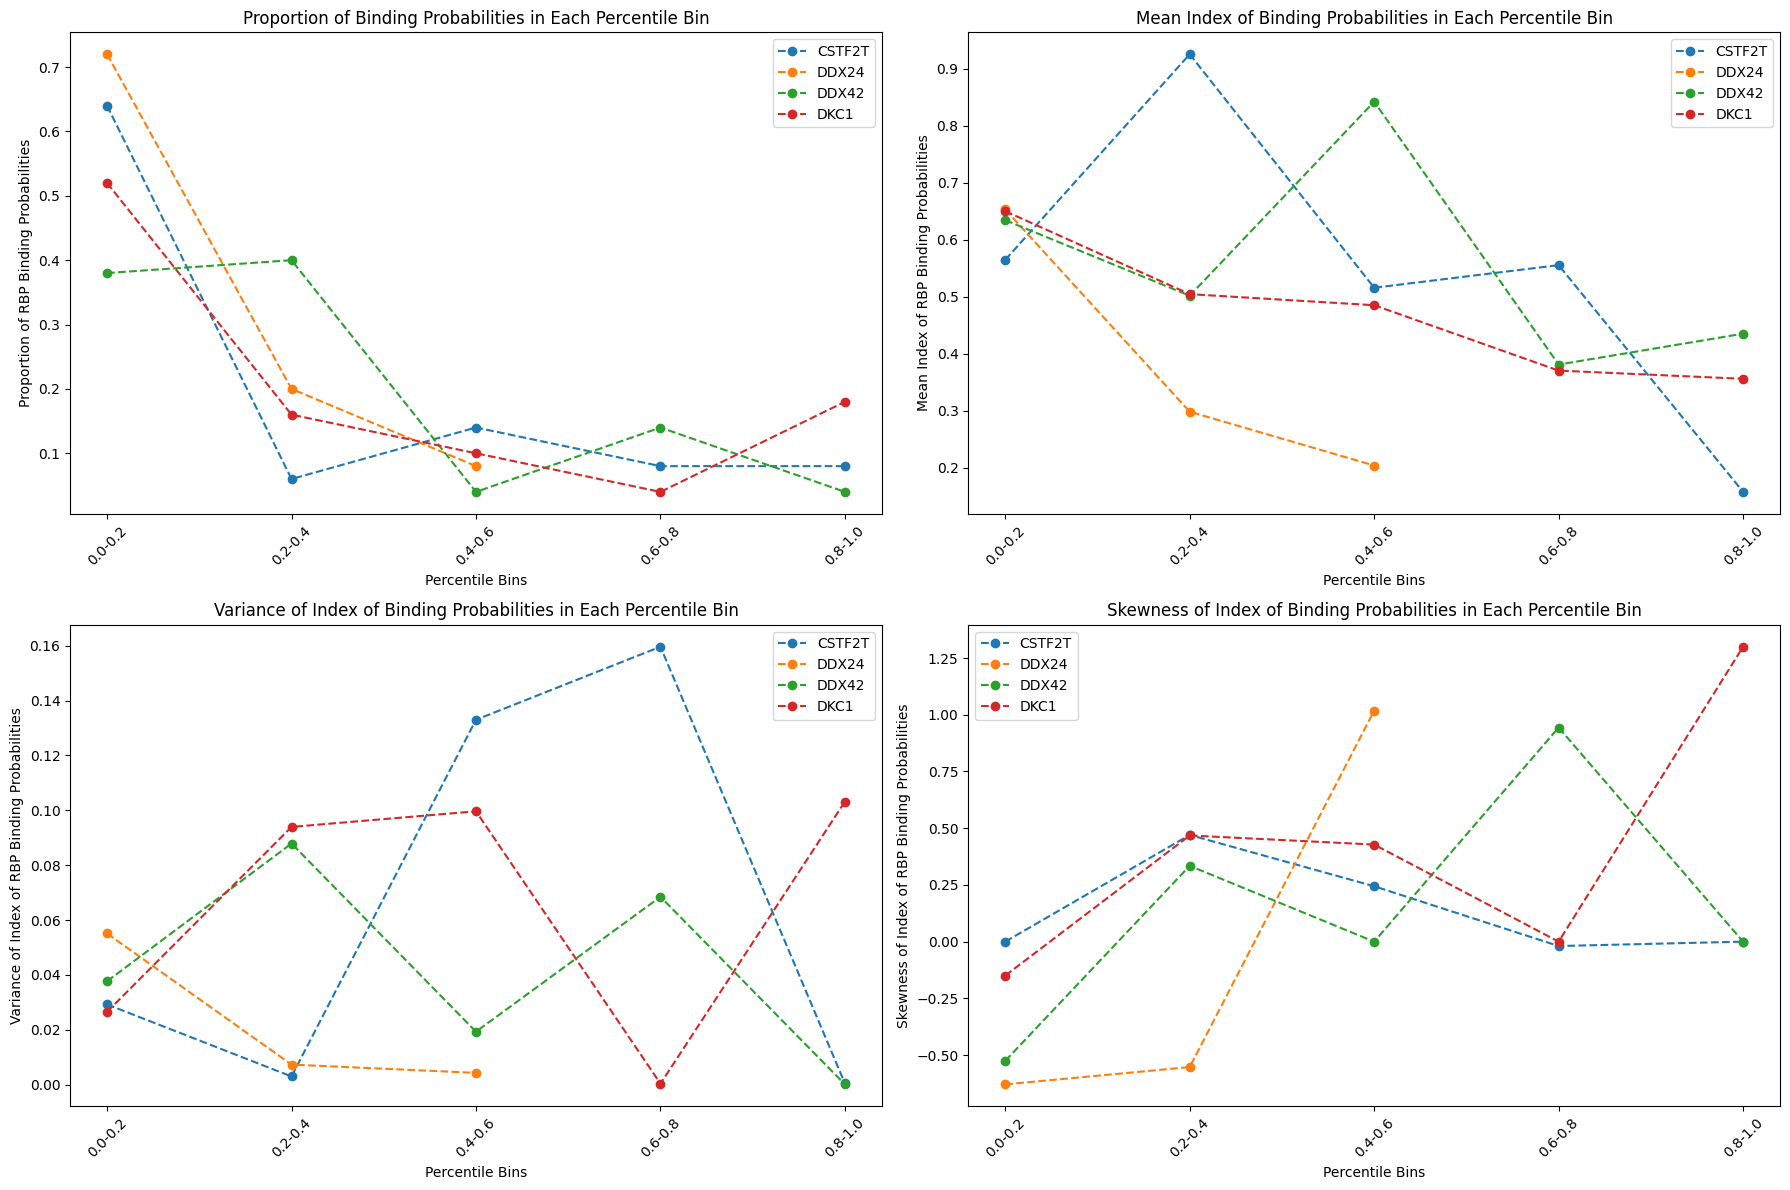

In [4]:
var_dict = {'Proportion': {}, 'Mean': {},'Variance': {},'Skew': {}}
N = 5
indices = np.arange(50, 50 + 10 * len(df), 10)
normalized_indices = indices / indices.max()
for rbp in sample_proteins:
    bps = df[rbp].values
    bins = np.linspace(0, 1, N + 1)
    bin_indices = np.digitize(bps, bins) - 1
    proportion_values, mean_index_values, variance_index_values, skew_index_values = [], [], [], []
    for i in range(N):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            mean_index_values.append(normalized_indices[indices_in_bin].mean())
            variance_index_values.append(normalized_indices[indices_in_bin].var())
            proportion_values.append(len(indices_in_bin) / len(indices))
            skew_index_values.append(skew(normalized_indices[indices_in_bin]))
        else:
            mean_index_values.append(np.nan)
            variance_index_values.append(np.nan)
            proportion_values.append(np.nan)
            skew_index_values.append(np.nan)
    var_dict['Proportion'][rbp], var_dict['Mean'][rbp] = proportion_values, mean_index_values
    var_dict['Variance'][rbp], var_dict['Skew'][rbp] = skew_index_values = variance_index_values, skew_index_values
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, (key, title, ylabel) in zip(axes.flatten(), 
                                    [('Proportion', 'Proportion of Binding Probabilities in Each Percentile Bin', 'Proportion of RBP Binding Probabilities'),
                                     ('Mean', 'Mean Index of Binding Probabilities in Each Percentile Bin', 'Mean Index of RBP Binding Probabilities'),
                                     ('Variance', 'Variance of Index of Binding Probabilities in Each Percentile Bin', 'Variance of Index of RBP Binding Probabilities'),
                                     ('Skew', 'Skewness of Index of Binding Probabilities in Each Percentile Bin', 'Skewness of Index of RBP Binding Probabilities')]):
    for rbp in var_dict[key]:
        ax.plot(range(N), var_dict[key][rbp], marker='o', linestyle='--', label=rbp)
    ax.set_title(title)
    ax.set_xlabel('Percentile Bins')
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(N))
    ax.set_xticklabels([f'{i/N:.1f}-{(i+1)/N:.1f}' for i in range(N)], rotation=45)
    ax.legend()
plt.tight_layout()
plt.show()

This code creates a series of subplots to visualize the binding probabilities of RNA-binding proteins (RBPs) and their Fourier Transform reconstructions. Each subplot shows the following:

1. **Original Binding Probabilities**: The original binding probabilities of the RBP across the RNA sequence are plotted as a semi-transparent line.
2. **Fourier Reconstruction**: The reconstructed signal using the top K Fourier components is plotted as dashed lines for different values of K (3, 7, and 12).

The subplots provide a comparison between the original binding probabilities and their Fourier Transform reconstructions, highlighting how well the top K Fourier components capture the signal.

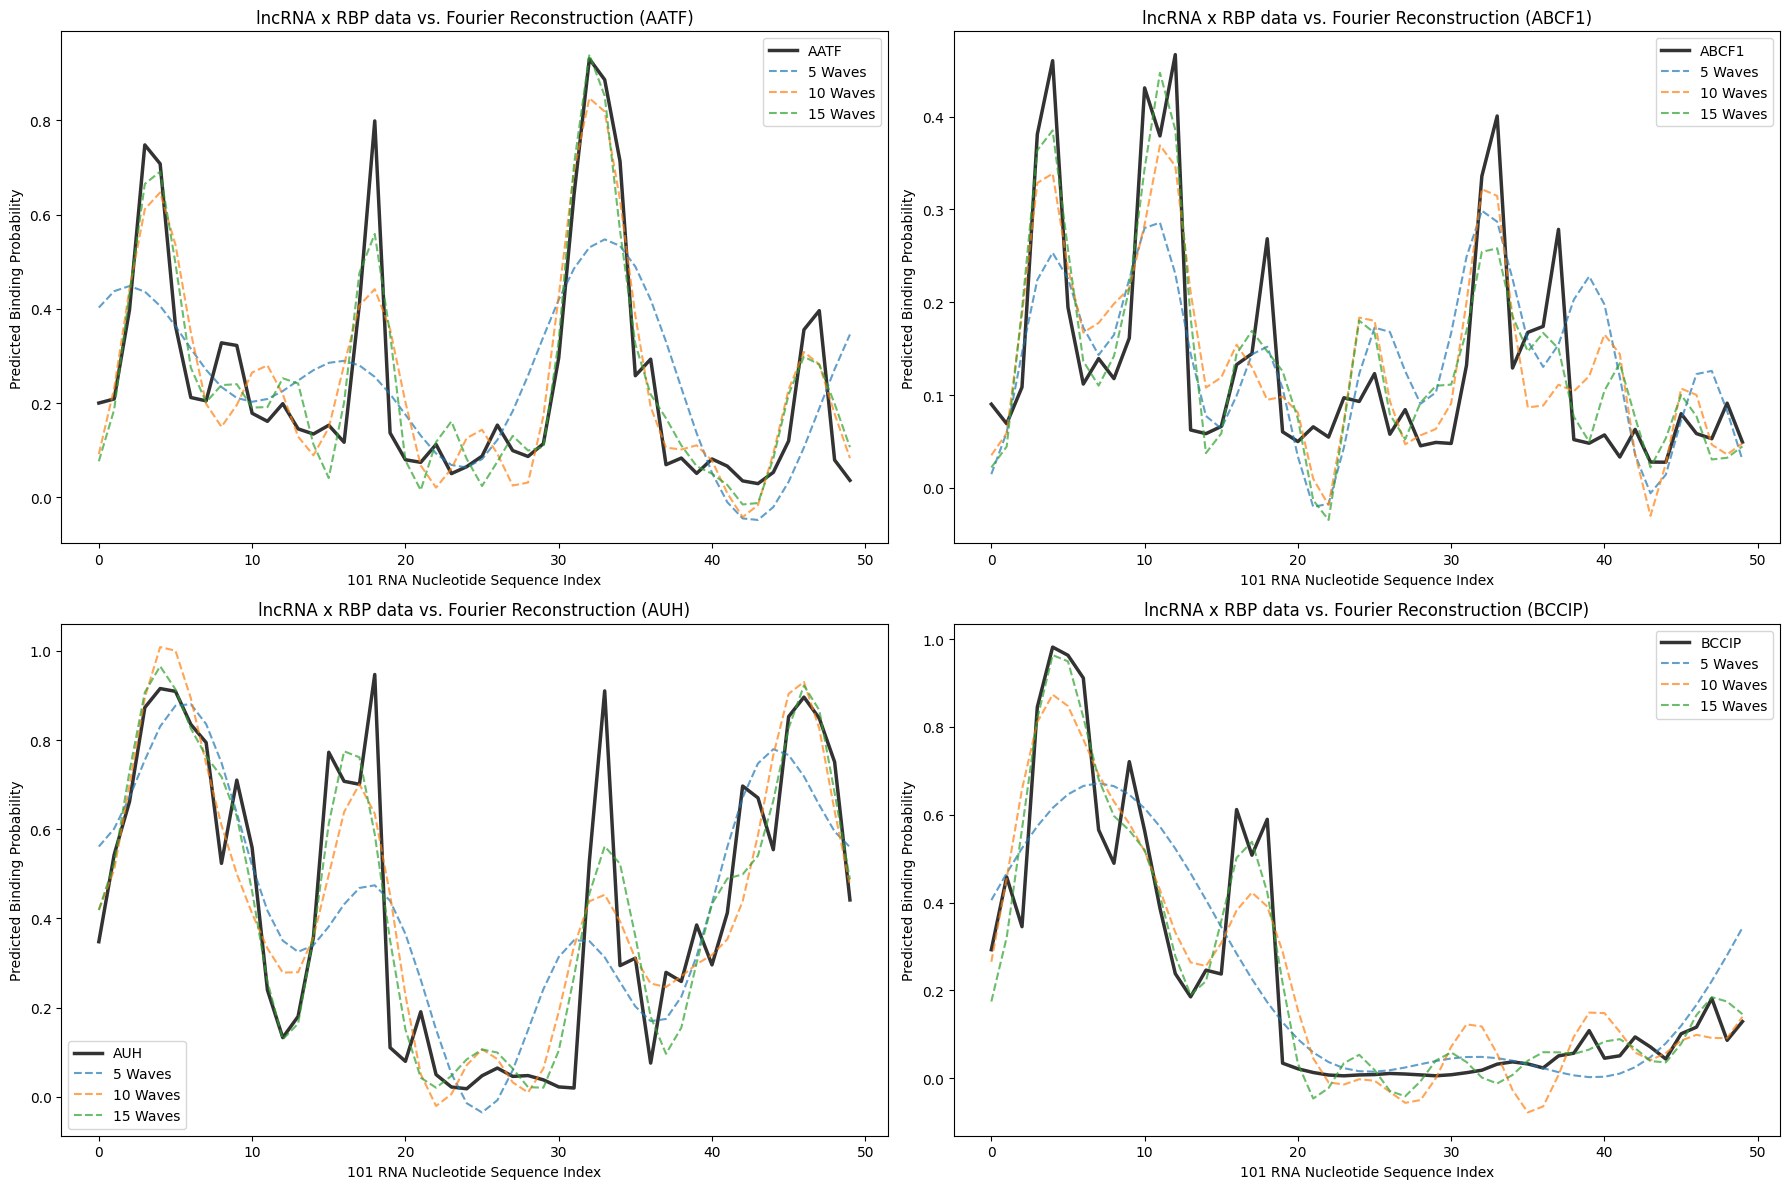

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, rbp in zip(axes.flatten(), df.columns[2:6]):
    bps = df[rbp].values
    n = len(bps)
    K = [5, 10, 15]
    bps_fft = np.fft.fft(bps)
    freqs = np.fft.fftfreq(n, d=1)
    magnitudes = np.abs(bps_fft) / n
    indices_sorted = np.argsort(magnitudes)[::-1]
    
    # Plot the original data with increased linewidth and alpha
    ax.plot(np.arange(n), bps, label=rbp, color='black', linewidth=2.5, alpha=0.8)
    
    for k in K:
        top_indices = indices_sorted[:k]
        filtered_fft = np.zeros_like(bps_fft, dtype=complex)
        filtered_fft[top_indices] = bps_fft[top_indices]
        filtered_fft[-top_indices] = bps_fft[-top_indices]
        y_reconstructed = np.fft.ifft(filtered_fft).real
        
        # Plot the reconstructed data with alpha
        ax.plot(np.arange(n), y_reconstructed, label=f'{k} Waves', linestyle='--', alpha=0.7)
    
    ax.set_title(f"lncRNA x RBP data vs. Fourier Reconstruction ({rbp})")
    ax.set_xlabel('101 RNA Nucleotide Sequence Index')
    ax.set_ylabel('Predicted Binding Probability')
    ax.legend()
plt.tight_layout()
plt.show()

## insert correlation explanation

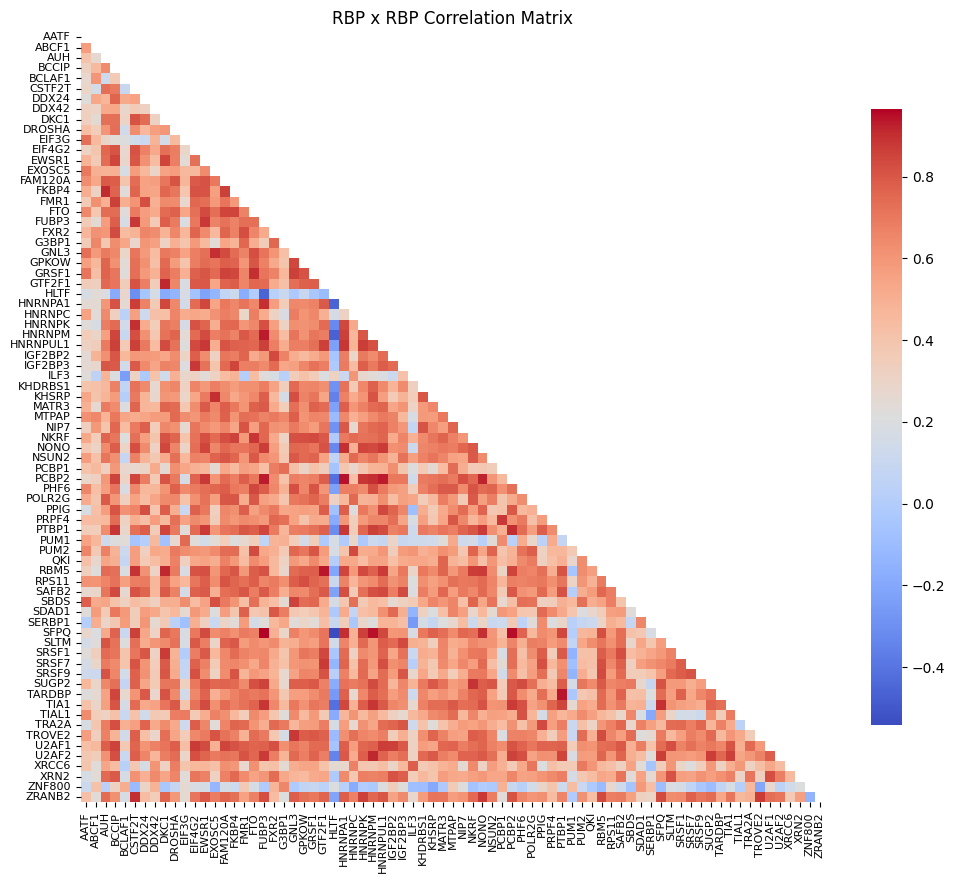

In [6]:
protein_columns = df.columns[2:]
correlation_matrix = df[protein_columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt='.2f', cbar_kws={"shrink": .8},
            xticklabels=protein_columns, yticklabels=protein_columns)
plt.title('RBP x RBP Correlation Matrix')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

## Extracting Features

The `process_file` function processes a given file containing lncRNA x RBP predicted binding interactions and extracts various features. Here is a summary of its steps:

1. **Read Data**: Reads the input file into a DataFrame.
2. **Initialize Variables**: Sets up variables for the number of bins (`N`), top Fourier frequencies (`K`), and autocorrelation lags (`L`).
3. **Percentile-based Summary Statistics**:
    - Bins the binding probabilities for each protein into `N` bins = [0 , 1/N] , ... , [N-1/N , 1].
    - Calculates the proportion, mean, variance, and skew forming the distribution of binding probabilites within each bin.
    - Stores the binned summary statistics in a dictionary.
4. **Top K Fourier Frequencies and Magnitudes**:
    - Computes the Fourier transform of the signal for each protein.
    - Extracts the top `K` more relevant frequencies and their respective magnitudes.
    - Stores these values in the dictionary.
5. **Correlation Matrix**:
    - Computes the correlation of binding probabilties between each pair of proteins.
    - Stores these values in the dictionary.
6. **Convert to DataFrame**: Converts the dictionary of features into a single-row DataFrame and returns it.

In [ ]:
# Computationally Optimized Feature Extraction
# ---------------------------------------------
# 1. Define your feature_extraction function
# ---------------------------------------------
def feature_extraction(df, N=0, K=0, lags=True):
    """
    Extract features for a single DataFrame `df`. 
    Returns a 1-row DataFrame containing the computed features.

    df: DataFrame with at least 3 columns (df.columns[2:] used for RBP variables).
    N : number of bins for binning-based stats
    K : number of top FFT frequencies
    L : maximum lag for autocorrelation
    lags: boolean to determine if lag calculations should be performed
    """
    # Identify columns to process
    RBPs = df.columns[2:]  # adjust as needed
    M = len(RBPs)          # number of RBP columns

    # Convert RBP columns to NumPy array for faster access
    data_array = df[RBPs].values
    n_points = len(df)

    # Dictionary to hold final feature values
    feature_dict = {}

    # -----------------------------------------
    # (A) Bin-based statistics: proportion, mean, variance, skew
    # -----------------------------------------
    bins = np.linspace(0, 1, N+1)
    indices = np.arange(50, 50 + 10*n_points, 10)
    normalized_indices = indices / indices.max()

    for col_idx, rbp in enumerate(RBPs):
        bps = data_array[:, col_idx]

        # Digitize bps into bins [0..N-1]
        bin_indices = np.digitize(bps, bins) - 1

        # Group once to avoid repeated np.where
        grouped_indices = [[] for _ in range(N)]
        for i, bin_idx in enumerate(bin_indices):
            if 0 <= bin_idx < N:
                grouped_indices[bin_idx].append(i)

        # Compute stats for each bin
        for i in range(N):
            idxs = grouped_indices[i]
            prefix = f"{rbp}_percentile_bin_{i}"

            if len(idxs) > 0:
                bin_norm = normalized_indices[idxs]
                feature_dict[f"{prefix}_proportion"] = len(idxs) / n_points
                feature_dict[f"{prefix}_mean"]       = bin_norm.mean()
                feature_dict[f"{prefix}_variance"]   = bin_norm.var()
                feature_dict[f"{prefix}_skew"]       = skew(bin_norm)
            else:
                feature_dict[f"{prefix}_proportion"] = np.nan
                feature_dict[f"{prefix}_mean"]       = np.nan
                feature_dict[f"{prefix}_variance"]   = np.nan
                feature_dict[f"{prefix}_skew"]       = np.nan

    # -----------------------------------------
    # (B) Top K FFT frequencies
    # -----------------------------------------
    if K > 0:
        for col_idx, rbp in enumerate(RBPs):
            bps = data_array[:, col_idx]
            n_i = len(bps)

            bps_fft = np.fft.fft(bps)
            freqs   = np.fft.fftfreq(n_i, d=1.0)
            mags    = np.abs(bps_fft) / n_i

            # Find indices of top K using argpartition (O(n)) if K < n_i
            if K < n_i:
                top_k_idx = np.argpartition(mags, -K)[-K:]
                top_k_idx = top_k_idx[np.argsort(mags[top_k_idx])[::-1]]
            else:
                top_k_idx = np.argsort(mags)[::-1]

            for rank, idx in enumerate(top_k_idx, start=1):
                feature_dict[f"{rbp}_Frequency_{rank}"] = freqs[idx]
                feature_dict[f"{rbp}_Magnitude_{rank}"] = mags[idx]

    # -----------------------------------------
    # (C) Correlation Calculations
    # -----------------------------------------
    if lags:
        # Vectorized correlation among columns
        corr_matrix = pd.DataFrame(data_array, columns=RBPs).corr()
        for i in range(M):
            for j in range(i+1, M):
                rbp1, rbp2 = RBPs[i], RBPs[j]
                feature_dict[f"{rbp1}_x_{rbp2}"] = corr_matrix.iloc[i, j]

    # Return single-row DataFrame
    return pd.DataFrame([feature_dict])

In [2]:
def process_files_with_progress(file_paths, N=0, K=0, lags=True):
    """
    Serially process multiple files, showing a tqdm progress bar.
    Returns a DataFrame with one row per file.
    """
    from tqdm import tqdm

    combined_df = []
    row_names = []
    error_files = []
    processed_files = 0

    with tqdm(file_paths, desc="Extracting Features", unit="lncRNA") as pbar:
        for path in pbar:
            try:
                # Read data once
                df = pd.read_csv(path, sep='\t')
                
                # Extract features
                result_df = feature_extraction(df, N=N, K=K, lags=lags)
                
                # Accumulate results
                combined_df.append(result_df)
                
                # Optionally, create a meaningful row name from filename
                row_names.append(os.path.basename(path).replace("_predictions.tsv", ""))

                processed_files += 1
            except Exception as e:
                error_files.append(path)
                continue

    # Concatenate all single-row DataFrames
    final_df = pd.concat(combined_df).set_index(pd.Index(row_names))
    return final_df, error_files, processed_files

In [ ]:
N, K, lags = 10, 50, True
directory_path = r"C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\lncRNA_x_RBP_Data"

# Initialize variables
errors = []
processed_files = 0

# Get the list of files
files = [os.path.join(folder_path, filename)
         for folder in os.listdir(directory_path)
         if os.path.isdir(folder_path := os.path.join(directory_path, folder))
         for filename in os.listdir(folder_path)
         if filename.endswith(".tsv")]

# Process files in smaller chunks to avoid memory issues
chunk_size = 1000  # Number of files to process at a time
all_features_df_list = []

output_csv_path = os.path.join(r"C:\Users\simeo\Documents", f"final_features_N{N}_K{K}{"_Corr" if lags else ""}.csv")
print(f"Processing {len(files)} files in chunks of {chunk_size}...")

for i in range(0, len(files), chunk_size):
    chunk_files = files[i:i + chunk_size]
    print(f"Processing chunk {i // chunk_size + 1}...")
    chunk_features_df, chunk_errors, chunk_processed_files = process_files_with_progress(chunk_files, N=N, K=K, lags=lags)
    all_features_df_list.append(chunk_features_df)
    errors.extend(chunk_errors)
    processed_files += chunk_processed_files

    # Save the chunk to the CSV file
    if i == 0:
        # For the first chunk, write the header
        chunk_features_df.to_csv(output_csv_path, mode='w')
    else:
        # For subsequent chunks, append without writing the header
        chunk_features_df.to_csv(output_csv_path, mode='a', header=False)

# Combine all chunks into a single DataFrame
all_features_df = pd.concat(all_features_df_list)

In [ ]:
PCS = 4  # Specify the number of principal components to include
pca_components_df = pd.DataFrame(pca.components_, columns=all_features_df.columns)
pca_components_df.index = [f"PC{i+1}" for i in range(len(pca_components_df))]

# Extract unique protein names from column names
proteins = list({col.split('_')[0] for col in pca_components_df.columns})

# Combine the results into a DataFrame
combined_results = []

for protein in proteins:
    # Filter columns associated with the current protein
    protein_columns = [col for col in pca_components_df.columns if col.startswith(protein)]
    protein_frequency_columns = [col for col in protein_columns if 'Frequency' in col]
    protein_magnitude_columns = [col for col in protein_columns if 'Magnitude' in col]

    # Extract loadings for the first K PCs for frequency and magnitude variables
    for pc in range(1, PCS + 1):
        pc_label = f"PC{pc}"
        protein_pc_frequency_loadings = pca_components_df.loc[pc_label, protein_frequency_columns]
        protein_pc_magnitude_loadings = pca_components_df.loc[pc_label, protein_magnitude_columns]

        # Combine frequency and magnitude loadings into a DataFrame
        protein_combined_data = pd.DataFrame({
            'Feature': protein_frequency_columns + protein_magnitude_columns,
            'Loading Value': list(protein_pc_frequency_loadings) + list(protein_pc_magnitude_loadings),
            'Type': ['Frequency'] * len(protein_frequency_columns) + ['Magnitude'] * len(protein_magnitude_columns),
            'Protein': protein,
            'Principal Component': pc_label
        })
        combined_results.append(protein_combined_data)

# Concatenate all protein data into a single DataFrame
final_combined_df = pd.concat(combined_results, ignore_index=True)
final_combined_df

import plotly.express as px

# Prepare the data for the 3D scatter plot
final_combined_df['Category'] = final_combined_df['Type']  # Add a category column for better visualization
final_combined_df['Index'] = final_combined_df['Feature'].str.extract(r'_(\d+)$').astype(int)  # Extract index from feature names

from plotly.subplots import make_subplots

import plotly.graph_objects as go

# Prepare the data for the 3D scatter plot
final_combined_df['Category'] = final_combined_df['Type']  # Add a category column for better visualization
final_combined_df['Index'] = final_combined_df['Feature'].str.extract(r'_(\d+)$').astype(int)  # Extract index from feature names

# Create a 2x2 subplot figure
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=[f"3D Line Plot of {pc}" for pc in final_combined_df['Principal Component'].unique()]
)

# Iterate over each principal component and add a 3D line plot to the subplot
unique_pcs = final_combined_df['Principal Component'].unique()
for i, pc in enumerate(unique_pcs):
    pc_data = final_combined_df[final_combined_df['Principal Component'] == pc]

    # Separate data for frequency and magnitude
    frequency_data = pc_data[pc_data['Type'] == 'Frequency']
    magnitude_data = pc_data[pc_data['Type'] == 'Magnitude']

    # Iterate over each protein to create separate line groups
    for protein in proteins:
        protein_frequency_data = frequency_data[frequency_data['Protein'] == protein]
        protein_magnitude_data = magnitude_data[magnitude_data['Protein'] == protein]

        # Create the 3D line plot for frequency
        frequency_scatter3d = go.Scatter3d(
            x=protein_frequency_data['Protein'],
            y=protein_frequency_data['Index'],
            z=protein_frequency_data['Loading Value'],
            mode='lines+markers',
            line=dict(width=2, color='blue'),
            marker=dict(size=2),
            name=f"{pc} - Frequency - {protein}",
            legendgroup=f"{pc} - Frequency - {protein}",
            text=protein_frequency_data['Category'],
            hoverinfo='text+x+y+z'
        )

        # Create the 3D line plot for magnitude
        magnitude_scatter3d = go.Scatter3d(
            x=protein_magnitude_data['Protein'],
            y=protein_magnitude_data['Index'],
            z=protein_magnitude_data['Loading Value'],
            mode='lines+markers',
            line=dict(width=2, color='red'),
            marker=dict(size=2),
            name=f"{pc} - Magnitude - {protein}",
            legendgroup=f"{pc} - Magnitude - {protein}",
            text=protein_magnitude_data['Category'],
            hoverinfo='text+x+y+z'
        )

        # Determine the row and column for the subplot
        row = i // 2 + 1
        col = i % 2 + 1

        # Add the traces to the subplot
        fig.add_trace(frequency_scatter3d, row=row, col=col)
        fig.add_trace(magnitude_scatter3d, row=row, col=col)

    # Update the layout for the subplot
    fig.update_scenes(
        dict(
            xaxis=dict(
                title='Proteins',
                tickvals=list(range(len(proteins))),
                ticktext=proteins,
                tickfont=dict(size=10),  # Make tick text smaller
                tickmode='array',
            ),
            yaxis=dict(
                title='Fourier Waves',
                tickvals=list(range(1, 51)),
                ticktext=list(range(1, 51)),
                tickfont=dict(size=10),  # Make tick text smaller
                tickmode='array',
            ),
            zaxis_title='Loadings'
        ),
        row=row,
        col=col
    )

# Update the overall layout
fig.update_layout(
    width=1200,
    height=1000,
    title="3D Line Plots for Principal Components"
)

# Show the plot
fig.show()